## NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION

In this project we will be teaching a neural network to translate from French to English.  

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

In [8]:
### Requirements

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data files

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it tothe current directory.

In [9]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

# The files are all in Unicode, to simplify we will turn Unicode characters to ASCII
# make everything lowercase, and trim most punctuation.

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# To read the data file we will split the file into lines, and then split lines into pairs.  
# The files are all English → Other Language, so if we want to translate from Other Language 
# → English I added the reverse flag to `reverse` the pairs.




In [11]:
# Since there are a lot of example sentences and we want to train something quickly, 
# we’ll trim the data set to only relatively short and simple sentences.

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# The full process for preparing the data is:
# - Read text file and split into lines, split lines into pairs
# - Normalize text, filter by length and content
# - Make word lists from sentences in pairs

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['vous etes tres emotifs', 'you re very emotional']


## The Seq2Seq Model

A `Sequence to Sequence network`, or seq2seq network, or `Encoder Decoder network`, is a model consisting of two RNNs called the encoder and decoder.  
The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### The Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.  
  
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the `context vector` as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size,output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Preparing Training Data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.o train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence).  
While creating these vectors we will append the EOS token to both sequences.

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


# This is a helper function to print time elapsed 
# and estimated time remaining given the current time and progress %.

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# plotting results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Train
The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

### Evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

   
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 32s (- 8m 12s) (5 6%) 1.6821
1m 1s (- 7m 11s) (10 12%) 0.8925
1m 30s (- 6m 30s) (15 18%) 0.5757
1m 58s (- 5m 56s) (20 25%) 0.3915
2m 28s (- 5m 26s) (25 31%) 0.2752
2m 56s (- 4m 54s) (30 37%) 0.1999
3m 25s (- 4m 24s) (35 43%) 0.1500
3m 54s (- 3m 54s) (40 50%) 0.1160
4m 22s (- 3m 24s) (45 56%) 0.0933
4m 51s (- 2m 54s) (50 62%) 0.0758
5m 20s (- 2m 25s) (55 68%) 0.0650
5m 48s (- 1m 56s) (60 75%) 0.0562
6m 17s (- 1m 27s) (65 81%) 0.0505
6m 45s (- 0m 57s) (70 87%) 0.0465
7m 14s (- 0m 28s) (75 93%) 0.0421
7m 44s (- 0m 0s) (80 100%) 0.0388


<Figure size 432x288 with 0 Axes>

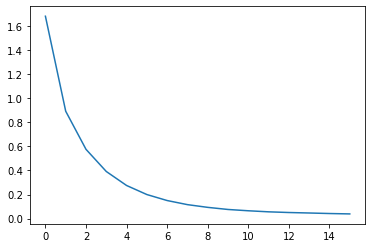

In [17]:
# train

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [18]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis content que tu ailles de nouveau bien
= i m glad you re all right again
< i m glad you re ok again <EOS>

> je suis fier de mon fils
= i m proud of my son
< i m proud of my son <EOS>

> je ne suis pas heureuse
= i m not happy
< i m not happy with this <EOS>

> je suis trop vieux pour elle
= i m too old for her
< i m too old for her job <EOS>

> c est un homme sur qui on peut compter
= he is a man you can rely upon
< he is a man you can rely upon <EOS>

> je suis ravie de vous aider
= i am glad to help you
< i am glad to see you again <EOS>

> je suis desole si ma presence t embarrasse
= i m sorry if my being here embarrasses you
< i m sorry if my being here embarrasses you <EOS>

> je crains de ne pas suivre
= i m afraid i don t follow
< i m afraid i have no experience <EOS>

> ils mentent tous
= they re all lying
< they re all for all right now <EOS>

> je suis juste un autre homme
= i m just another man
< i m just another man <EOS>



### Attention Decoder
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.  
  
Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs.

In [26]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 57s (- 14m 25s) (5 6%) 1.5563
1m 55s (- 13m 27s) (10 12%) 0.6873
2m 52s (- 12m 28s) (15 18%) 0.3568
3m 50s (- 11m 30s) (20 25%) 0.1981
4m 47s (- 10m 32s) (25 31%) 0.1221
5m 45s (- 9m 35s) (30 37%) 0.0847
6m 42s (- 8m 37s) (35 43%) 0.0648
7m 40s (- 7m 40s) (40 50%) 0.0529
8m 37s (- 6m 42s) (45 56%) 0.0457
9m 35s (- 5m 45s) (50 62%) 0.0409
10m 32s (- 4m 47s) (55 68%) 0.0376
11m 29s (- 3m 49s) (60 75%) 0.0349
12m 27s (- 2m 52s) (65 81%) 0.0335
13m 24s (- 1m 54s) (70 87%) 0.0316
14m 22s (- 0m 57s) (75 93%) 0.0302
15m 20s (- 0m 0s) (80 100%) 0.0289


<Figure size 432x288 with 0 Axes>

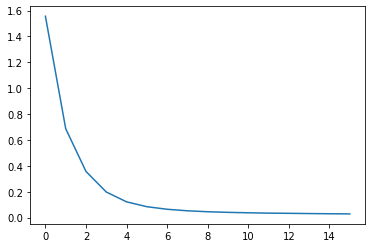

In [20]:
# training with attention

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

### Visualizing Attention
Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_3153/1690937169.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_3153/1690937169.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


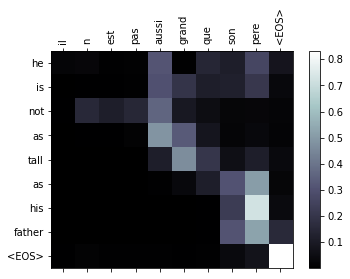

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


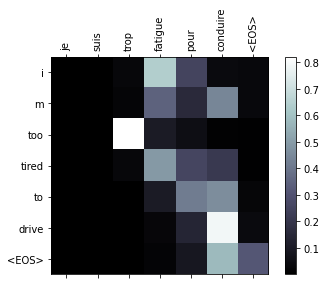

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


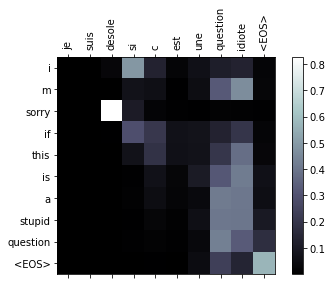

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


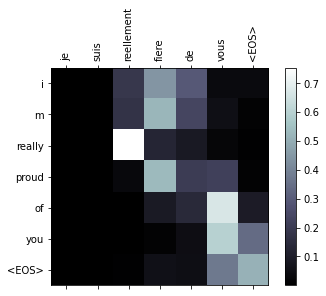

In [21]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

# Additional Experiments

* 임베딩 레이어 변경: nn.Embedding의 차원을 변경. 임베딩 차원의 크기가 모델의 성능에 영향을 줌
* Attention 메커니즘 변경: BahdanauAttention 대신에 LuongAttention 등 다른 attention 메커니즘을 사용
* GRU 레이어 변경: GRU 레이어의 은닉 상태 크기 또는 층 수를 변경
* 출력 레이어 변경: 출력 레이어의 크기를 조정
* Dropout 조정: self.dropout의 dropout 비율을 변경하여 모델의 일반화 성능에 어떤 영향을 미치는지 확인
* 최적화 알고리즘 변경, Learning Rate 변경, 데이터 전처리 변경: 데이터 전처리 과정을 변경하거나 다양한 텍스트 정제 기법을 시도

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
1m 1s (- 15m 21s) (5 6%) 1.1077
2m 3s (- 14m 25s) (10 12%) 0.2215
3m 7s (- 13m 31s) (15 18%) 0.0717
4m 7s (- 12m 21s) (20 25%) 0.0478
5m 7s (- 11m 15s) (25 31%) 0.0403
6m 7s (- 10m 12s) (30 37%) 0.0365
7m 7s (- 9m 9s) (35 43%) 0.0339
8m 7s (- 8m 7s) (40 50%) 0.0320
9m 8s (- 7m 6s) (45 56%) 0.0305
10m 8s (- 6m 5s) (50 62%) 0.0300
11m 8s (- 5m 4s) (55 68%) 0.0290
12m 8s (- 4m 2s) (60 75%) 0.0283
13m 9s (- 3m 2s) (65 81%) 0.0288
14m 9s (- 2m 1s) (70 87%) 0.0268
15m 9s (- 1m 0s) (75 93%) 0.0271
16m 9s (- 0m 0s) (80 100%) 0.0272


<Figure size 432x288 with 0 Axes>

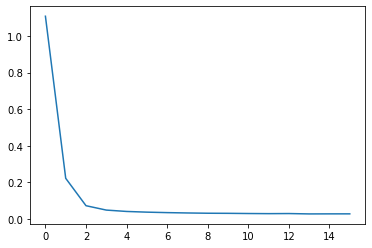

In [27]:
# training with attention

hidden_size = 256 # hidden size is doubled
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_3153/1690937169.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_3153/1690937169.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


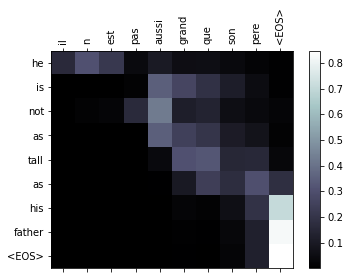

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


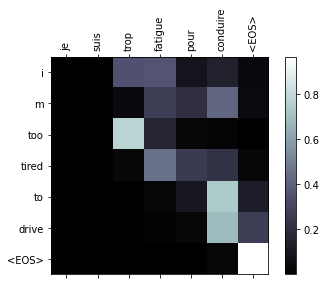

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


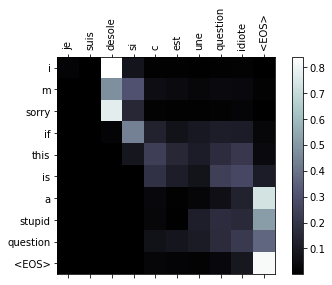

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


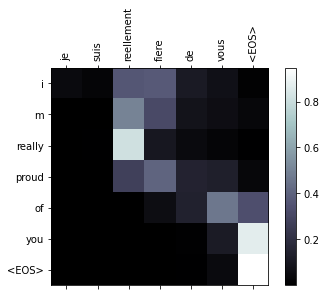

In [28]:
evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

최종적으로 loss가 더 떨어지는 것을 확인할 수 있었다. 